In [55]:
import pennylane as qml
import torch
import numpy as np

class QNGOptimizer(torch.optim.Optimizer):

    def __init__(self, params, lr=0.01, diag_approx=False, lam=0):
        defaults = dict(lr=0.01, diag_approx=False, lam=0)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss, metric_tensor = closure()

        for group in self.param_groups:
            for p in group["params"]:

                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0

                g = metric_tensor(weights)
                g += group["lam"] * np.identity(g.shape[0])

                state["step"] += 1

                d_p = torch.tensor(-group['lr'] * np.linalg.solve(g, grad))
                p.data.add_(d_p)

        return loss        

n_wires = 4

torch.manual_seed(42)
weights = torch.ones((n_wires,3), requires_grad=True)
bias = torch.zeros(1, requires_grad=True)
params = {"weights": weights, "bias": bias}
#opt = torch.optim.Adam([ weights, bias], lr=0.01)
opt = QNGOptimizer([weights, bias], lr=0.01)

def closure():
    opt.zero_grad()
    loss = loss_fnc(params)
    loss.backward()
    return loss, qml.metric_tensor(ref_circuit, approx="block-diag")


loss_history = []

@qml.qnode(qml.device("default.qubit.torch", wires=n_wires), diff_method="best")
def circuit(x, weights):
    # Embedding Ansatz
    for i in range(n_wires):
        qml.RY(2*torch.arccos(x),wires = i)

    # Variational Ansatz   
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])
    
    # Total magnetization in z-direction as cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

@qml.qnode(qml.device("default.qubit.torch", wires=n_wires), diff_method="best")
def ref_circuit(weights):
    # # Embedding Ansatz
    # for i in range(n_wires):
    #     qml.RY(2*torch.arccos(x),wires = i)

    # Variational Ansatz   
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])
    
    # Total magnetization in z-direction as cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(data, weights, bias):
    return circuit([data, weights]) + bias

def loss_fnc(params):
    x = torch.linspace(0,0.99,21,requires_grad=True)
    u_pred = my_model(x, params["weights"], params["bias"])
    grad_outputs = torch.ones_like(u_pred)
    dudx = torch.autograd.grad(u_pred, x, grad_outputs=grad_outputs, create_graph=True)[0]
    
    res = dudx - (4 * x**3 + x**2 - 2 * x - 0.5)
    loss_diff = torch.mean(res**2)
    loss_initial = torch.mean((my_model(torch.zeros_like(x),params["weights"], params["bias"]) - torch.ones_like(x))**2 )
    
    return loss_diff + loss_initial

def optimize(params, n=1000):
    loss_history = []

    for i in range(1,n+1):
        opt.step(closure)
        loss_val = loss_fnc(params)
        # opt.zero_grad()
        # loss_val = loss_fnc(params)
        # loss_val.backward()
        # opt.step()
        if i%100 == 0: print(f"Step: {i}  Loss: {loss_val}")
        loss_history.append(loss_val)

    return params, loss_history

%timeit -r1 -n1 optimize(params)

TypeError: circuit() missing 1 required positional argument: 'weights'

In [50]:
@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def ref_circuit(data):
    x = data[0]
    weights = data[1:]
    weights = weights.reshape((n_wires, 3))
    # Embedding Ansatz
    for i in range(n_wires):
        qml.RY(2*torch.arccos(x),wires = i)

    # Variational Ansatz   
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])
    
    # Total magnetization in z-direction as cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

weights = torch.ones(n_wires*3, requires_grad=True)
x = torch.linspace(0,0.99,21,requires_grad=True)
data = torch.hstack((x[0], weights))
indices = [ i+1 for i in range(n_wires*3)]
metric_tensor = qml.metric_tensor(ref_circuit, approx="block-diag", argnum=indices)
tmp1 = metric_tensor(data)
data = torch.hstack((x[2], weights))
metric_tensor = qml.metric_tensor(ref_circuit, approx="block-diag", argnum=indices)
tmp2 = metric_tensor(data)

torch.norm(tmp1[3:,3:]-tmp2[3:,3:])

# qng_cost = []
# opt = qml.QNGOptimizer(0.01)

# for _ in range(10):
#     theta = opt.step(ref_circuit, weights)
#     qng_cost.append(ref_circuit(weights))

tensor(0.0378, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

TypeError: circuit() missing 1 required positional argument: 'weights'

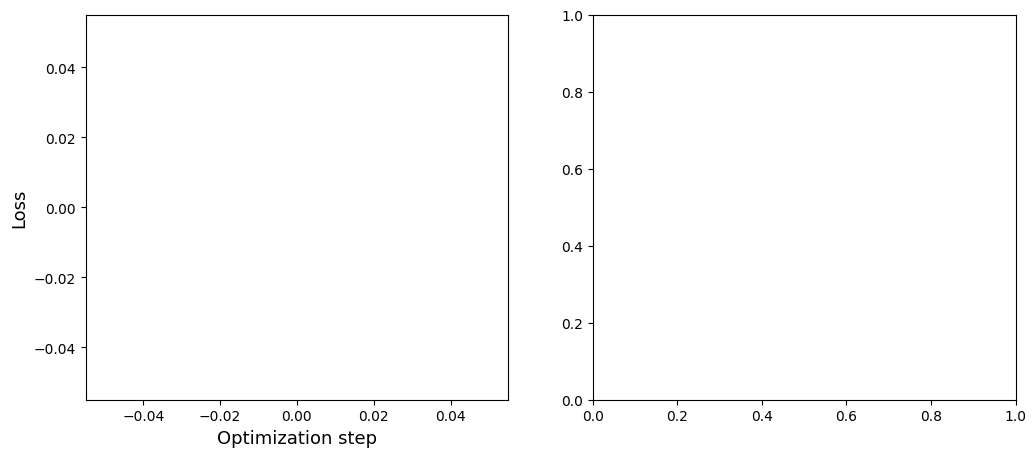

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = torch.linspace(0,0.99,21)
f_qc = my_model(x,params["weights"], params["bias"]).detach()
f_an = x
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()

TypeError: circuit() missing 1 required positional argument: 'weights'

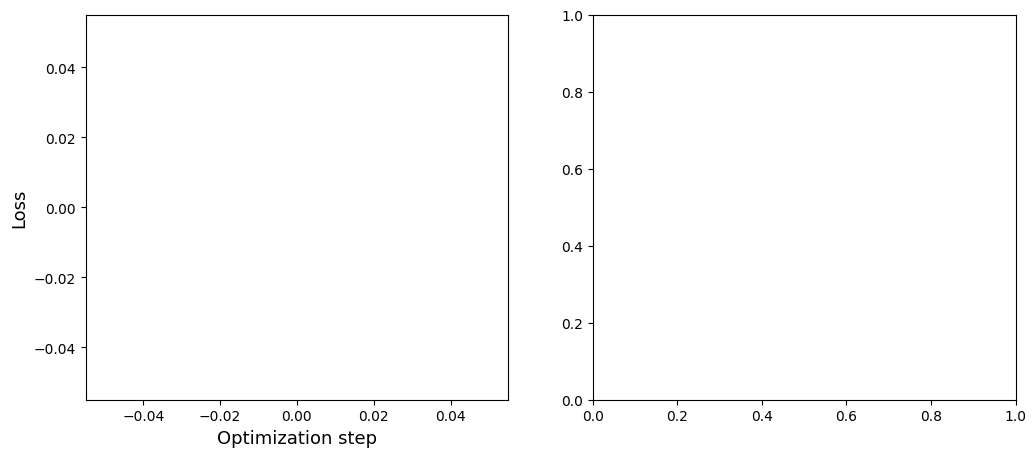

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = torch.linspace(0,0.99,21)
f_qc = my_model(x,params["weights"], params["bias"]).detach()
f_an = x
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()